In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split
import wandb
from sklearn.metrics import confusion_matrix
from types import SimpleNamespace
import random

In [ ]:
#optimizer class
class Optimizer:

    def __init__(self, learning_rate=0.01, epsilon=1e-4, beta=0.9, beta1=0.9, beta2=0.999):
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.beta = beta
        self.beta1 = beta1
        self.beta2 = beta2

    def sgd(self, parameters, grads, prev_u=None):

        for t in parameters.keys():
            parameters[t] -= self.learning_rate * grads[t]
        return parameters, prev_u

    def momentum_gradient_descent(self, parameters, grads, prev_u=None, beta=0.9):

        if prev_u is None:
            prev_u = {key: np.zeros_like(value) for key, value in parameters.items()}         # Initialize with zeros (u(-1)= 0)
        for t in parameters.keys():
            prev_u[t] = beta * prev_u[t] + grads[t]
            parameters[t] -= self.learning_rate * prev_u[t]                                   #prev_u[t] accumuklates the history vector
        return parameters, prev_u

    def nesterov_accelerated_gradient_descent(self, parameters, grads, prev_u=None, beta=0.9):

        if prev_u is None:
            prev_u = {t: np.zeros_like(value) for t, value in parameters.items()}             # initialize u(-1)= 0
        lookahead_params = {t: parameters[t] - beta * prev_u[t] for t in parameters.keys()}
        temp_grads = grads
        for t in parameters.keys():
            prev_u[t] = beta * prev_u[t] + self.learning_rate * temp_grads[t]                     #prev_u[t] accumuklates the history vector
            parameters[t] -= prev_u[t]
        return parameters, prev_u

    def rmsprop(self, parameters, grads, prev_u=None, beta=0.9):

        if prev_u is None:
            prev_u = {t: np.zeros_like(value) for t, value in parameters.items()}
        for t in parameters.keys():
            prev_u[t] = beta * prev_u[t] + (1 - beta) * grads[t] ** 2
            parameters[t] -= (self.learning_rate / (np.sqrt(prev_u[t]) + self.epsilon)) * grads[t]
        return parameters, prev_u

    def adam(self, parameters, grads, prev_u=None):

        if prev_u is None or "step" not in prev_u:                                  #initialization
            prev_u = {"m": {t: np.zeros_like(value) for t, value in parameters.items()},
                      "v": {t: np.zeros_like(value) for t, value in parameters.items()},
                      "step": 0}
        prev_u["step"] += 1
        step = prev_u["step"]
        for t in parameters.keys():
            prev_u["m"][t] = self.beta1 * prev_u["m"][t] + (1 - self.beta1) * grads[t]         #bias corrected moment estimate
            prev_u["v"][t] = self.beta2 * prev_u["v"][t] + (1 - self.beta2) * (grads[t] ** 2)
            m_hat = prev_u["m"][t] / (1 - self.beta1 ** step)
            v_hat = prev_u["v"][t] / (1 - self.beta2 ** step)
            parameters[t] -= (self.learning_rate * m_hat) / (np.sqrt(v_hat) + self.epsilon)     #update rule
        return parameters, prev_u

    def nadam(self, parameters, grads, prev_u=None):

        if prev_u is None or "step" not in prev_u:
            prev_u = {"m": {t: np.zeros_like(value) for t, value in parameters.items()},
                      "v": {t: np.zeros_like(value) for t, value in parameters.items()},
                      "step": 0}
        prev_u["step"] += 1
        step = prev_u["step"]
        for t in parameters.keys():
            prev_u["m"][t] = self.beta1 * prev_u["m"][t] + (1 - self.beta1) * grads[t]          #bias corrected moment estimate
            prev_u["v"][t] = self.beta2 * prev_u["v"][t] + (1 - self.beta2) * (grads[t] ** 2)
            m_hat = prev_u["m"][t] / (1 - self.beta1 ** step)
            v_hat = prev_u["v"][t] / (1 - self.beta2 ** step)
            nadam_update = (self.beta1 * m_hat +
                            (1 - self.beta1) * grads[t] / (1 - self.beta1 ** step))
            parameters[t] -= (self.learning_rate / (np.sqrt(v_hat) + self.epsilon)) * nadam_update    #update rule
        return parameters, prev_u


In [ ]:
#neural network class
class NeuralNetwork:
    def __init__(self, layer_sizes, weight_init="random", activation="sigmoid",beta=0.9, beta1=0.9, beta2=0.999, weight_decay=0.0):
        self.layer_sizes = layer_sizes
        self.weight_init = weight_init
        self.activation = activation
        self.weight_decay = weight_decay
        self.parameters = self.initialize_weights_bias(layer_sizes)
        self.beta = beta
        self.beta1 = beta1
        self.beta2 = beta2

    #activation functions
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return self.sigmoid(x) * (1 - self.sigmoid(x))

    def tanh(self, x):
        return np.tanh(x)

    def tanh_derivative(self, x):
        return 1 - np.tanh(x) ** 2

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return np.where(x > 0, 1, 0)

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=0, keepdims=True))
        return exp_z / np.sum(exp_z, axis=0, keepdims=True)


    def initialize_weights_bias(self, layer_size):          #weight and biases initializes
        parameters = {}          #empty dictionary to strore parameters(weights, biases)
        L = len(layer_size) - 1
        for i in range(1, L + 1):
            if self.weight_init == "xavier":
                parameters[f"W{i}"] = (np.random.randn(layer_size[i], layer_size[i-1]) *np.sqrt(2 / (layer_size[i] + layer_size[i-1])))
            else:               #random initialization
                parameters[f"W{i}"] = np.random.randn(layer_size[i], layer_size[i-1])
            parameters[f"b{i}"] = np.zeros((layer_size[i], 1))
        return parameters


    def one_hot_encode(self, y, num_classes):
        y = y.astype(int).flatten()
        one_hot = np.zeros((y.shape[0], num_classes))
        one_hot[np.arange(y.shape[0]), y] = 1
        return one_hot

    def load_and_preprocess_data(self):

        (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
        x_train = x_train.reshape(x_train.shape[0], -1) / 255.0
        x_test = x_test.reshape(x_test.shape[0], -1) / 255.0

        print("=" * 40)
        print("Fashion MNIST Dataset Details")
        print("=" * 40)
        print(f"Training Samples: {x_train.shape[0]}")
        print(f"Test Samples: {x_test.shape[0]}")
        print(f"Input Features: {x_train.shape[1]}")
        print("=" * 40)

        return (x_train, y_train), (x_test, y_test)

    def split_data(self):
        (x_train, y_train_raw), (x_test, y_test_raw) = self.load_and_preprocess_data()

          # split training data into train and validation sets (10% validation)
        x_train, x_val, y_train_raw, y_val_raw = train_test_split(x_train, y_train_raw, test_size=0.1, random_state=42)

         # One-hot encoding labels
        num_classes = len(np.unique(y_train_raw))
        self.num_classes = num_classes  # crucial to set explicitly here
        y_train_enc = self.one_hot_encode(y_train_raw, num_classes)
        y_val_enc = self.one_hot_encode(y_val_raw, num_classes)
        y_test_enc = self.one_hot_encode(y_test_raw, num_classes)
        print("=" * 40)
        print("Updated Fashion MNIST Dataset Details")
        print("=" * 40)
        print(f"Training Samples: {x_train.shape[0]}")
        print(f"Validation Samples: {x_val.shape[0]}")
        print(f"Test Samples: {x_test.shape[0]}")

        return x_train, y_train_raw, y_train_enc, x_val, y_val_raw, y_val_enc, x_test, y_test_raw, y_test_enc



    def forward_propagation(self, x_batch, y_batch_raw, num_of_hidden_layers, num_neurons):
        pre_activations = {}
        activations = {"h0": x_batch.T}
        for i in range(1, num_of_hidden_layers + 1):
            a_i = np.dot(self.parameters[f"W{i}"], activations[f"h{i-1}"]) + self.parameters[f"b{i}"]
            if self.activation == "sigmoid":
                h_i = self.sigmoid(a_i)
            elif self.activation == "relu":
                h_i = self.relu(a_i)
            elif self.activation == "tanh":
                h_i = self.tanh(a_i)
            else:
                raise ValueError("activation function not defined")
            pre_activations[f"a{i}"] = a_i
            activations[f"h{i}"] = h_i

        # Output layer
        L = num_of_hidden_layers + 1
        a_L = np.dot(self.parameters[f"W{L}"], activations[f"h{L-1}"]) + self.parameters[f"b{L}"]
        h_L = self.softmax(a_L)      #y_hat
        pre_activations[f"a{L}"] = a_L
        activations[f"h{L}"] = h_L
        return h_L.T, pre_activations, activations


    def backpropagation(self, x_batch, y_batch_enc, pre_activations, activations,optimizer, batch_size, prev_v, weight_decay):

        grads = {}
        L = len(self.layer_sizes) - 1

        # talk to the last layer
        nabla_a_L = activations[f"h{L}"].T - y_batch_enc                 #(batch_size, num_classes)

        # Output layer gradients
        grads[f"W{L}"] = (np.dot(nabla_a_L.T, activations[f"h{L-1}"].T)
                          + weight_decay * self.parameters[f"W{L}"]) / batch_size
        grads[f"b{L}"] = np.sum(nabla_a_L, axis=0, keepdims=True).T / batch_size

        # Hidden layers
        for k in range(L-1, 0, -1):
            nabla_h_k = np.dot(self.parameters[f"W{k+1}"].T, nabla_a_L.T)
            if self.activation == "sigmoid":
                nabla_a_k = nabla_h_k * self.sigmoid_derivative(pre_activations[f"a{k}"])
            elif self.activation == 'relu':
                nabla_a_k = nabla_h_k * self.relu_derivative(pre_activations[f"a{k}"])
            elif self.activation == "tanh":
                nabla_a_k = nabla_h_k * self.tanh_derivative(pre_activations[f"a{k}"])
            else:
                raise ValueError("Activation not defined.")

            grads[f"W{k}"] = (np.dot(nabla_a_k, activations[f"h{k-1}"].T)+ weight_decay * self.parameters[f"W{k}"]) / batch_size
            grads[f"b{k}"] = np.sum(nabla_a_k, axis=1, keepdims=True) / batch_size
            nabla_a_L = nabla_a_k.T

        # Apply chosen optimizer function
        if isinstance(optimizer, Optimizer):
            raise ValueError("Should be  an optimizer method sgd, adam) etc.")
        self.parameters, prev_v = optimizer(self.parameters, grads, prev_v)
        return self.parameters, prev_v


    def compute_loss(self, y_true, y_pred, batch_size, weight_decay):
        epsilon = 1e-8
        l2_norm = sum(np.sum(np.square(self.parameters[f"W{i}"])) for i in range(1, len(self.layer_sizes)))
        cross_entropy = -np.mean(np.sum(y_true * np.log(y_pred + epsilon), axis=1))
        return cross_entropy + 0.5 * weight_decay * l2_norm


    def plot_loss_chart(self, epochs, train_loss, val_loss):
        plt.figure(figsize=(8, 6))
        plt.plot(epochs, train_loss, marker='o', label="Training Loss")
        plt.plot(epochs, val_loss, marker='o', label="Validation Loss")
        plt.title("Loss vs. Epoch")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        return plt.gcf()           #current figure


    def train_model(self, x_train, y_train_raw, y_train_enc,x_val, y_val_raw, y_val_enc,num_hidden_layers, num_neurons, optimizer_type,
                    learning_rate, num_epochs, batch_size, weight_decay):


        self.layer_sizes = [x_train.shape[1]] + [num_neurons]*num_hidden_layers + [self.num_classes]
        # initialize
        self.parameters = self.initialize_weights_bias(self.layer_sizes)

        # Instantiate optimizer
        opt = Optimizer(learning_rate=learning_rate, beta=self.beta, beta1=self.beta1, beta2=self.beta2)
        if optimizer_type == 'sgd':
            optimizer_function = opt.sgd
        elif optimizer_type == 'momentum':
            optimizer_function = opt.momentum_gradient_descent
        elif optimizer_type == 'nesterov':
            optimizer_function = opt.nesterov_accelerated_gradient_descent
        elif optimizer_type == 'rmsprop':
            optimizer_function = opt.rmsprop
        elif optimizer_type == 'adam':
            optimizer_function = opt.adam
        elif optimizer_type == 'nadam':
            optimizer_function = opt.nadam
        else:
            raise ValueError(f"optimizer not defined: {optimizer_type}")

        prev_u = None
        train_losses = []
        val_losses = []
        n_samples = x_train.shape[0]


        for epoch in range(1, num_epochs+1):
            epoch_loss = 0.0
            # Mini-batch training
            for i in range(0, n_samples, batch_size):
                batch_x = x_train[i:i+batch_size, :]
                batch_enc = y_train_enc[i:i+batch_size, :]
                # Forward propagation
                y_hat, pre_acts, acts = self.forward_propagation(batch_x, None, num_hidden_layers, num_neurons)
                # Backward prop & parameter update
                self.parameters, prev_u = self.backpropagation(batch_x, batch_enc, pre_acts, acts,optimizer_function, batch_x.shape[0],prev_u, weight_decay)
                # Accumulate loss
                epoch_loss += self.compute_loss(batch_enc, y_hat, batch_x.shape[0], weight_decay)

            # Average training loss for this epoch
            avg_train_loss = epoch_loss / (n_samples / batch_size)
            train_losses.append(avg_train_loss)

            # Validation
            y_hat_val, _, _ = self.forward_propagation(x_val, None, num_hidden_layers, num_neurons)
            val_loss = self.compute_loss(y_val_enc, y_hat_val, x_val.shape[0], weight_decay)
            val_losses.append(val_loss)

            # Compute training accuracy
            y_hat_full, _, _ = self.forward_propagation(x_train, None, num_hidden_layers, num_neurons)
            train_acc = np.mean(np.argmax(y_hat_full, axis=1) == y_train_raw)

            # Compute validation accuracy
            val_acc = np.mean(np.argmax(y_hat_val, axis=1) == y_val_raw)

            # Log to Weights & Biases
            wandb.log({
                "train_loss": avg_train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "epoch": epoch
            })

            print(f"Epoch {epoch}: train_loss={avg_train_loss:.4f}, val_loss={val_loss:.4f}, "
                  f"train_acc={train_acc:.4f}, val_acc={val_acc:.4f}")

        # Plot
        epochs_range = list(range(1, num_epochs + 1))
        fig = self.plot_loss_chart(epochs_range, train_losses, val_losses)
        plt.show()

        return self.parameters, train_losses, val_losses



    def test_model(self, x_test, y_test_raw, y_test_enc, num_hidden_layers, num_neurons, batch_size):
        y_hat, _, _ = self.forward_propagation(x_test, None, num_hidden_layers, num_neurons)
        test_loss = self.compute_loss(y_test_enc, y_hat, x_test.shape[0], self.weight_decay)
        y_hat_labels = np.argmax(y_hat, axis=1)
        test_accuracy = np.mean(y_hat_labels == y_test_raw)

        print(f"Test Loss: {test_loss:.4f} \tTest Accuracy: {test_accuracy:.4f}")
        return test_loss, test_accuracy



In [ ]:
#sweep configuration
sweep_config = {
    "name": "sweep 100 runs",
    "method": "bayes",
    "metric": {"name": "val_acc", "goal": "maximize"},         #maximize validation accuracy
    "parameters": {
        "epochs": {"values": [5, 10]},
        "num_hidden_layers": {"values": [3, 4, 5]},
        "num_neurons": {"values": [32, 64, 128]},
        "weight_decay": {"values": [0, 0.0005, 0.5]},
        "learning_rate": {"values": [1e-3, 1e-4]},
        "optimizer": {"values": ["sgd", "momentum", "nesterov", "rmsprop", "adam", "nadam"]},
        "batch_size": {"values": [16, 32, 64]},
        "weight_init": {"values": ["random", "xavier"]},
        "activation": {"values": ["sigmoid", "tanh", "relu"]}
    }
}

# Create the sweep
sweep_id = wandb.sweep(sweep_config, project="A1_MA23M018")  #https://wandb.ai/pritamapcr-indian-institute-of-technology-madras/A1_MA23M018/sweeps/f07knmct


Create sweep with ID: f07knmct
Sweep URL: https://wandb.ai/pritamapcr-indian-institute-of-technology-madras/A1_MA23M018/sweeps/f07knmct


In [ ]:
def main():
    with wandb.init() as run:
        config = wandb.config
        run_name = (f"hl_{config.num_hidden_layers}_bs_{config.batch_size}_"
                    f"ac_{config.activation}_ep_{config.epochs}")
        wandb.run.name = run_name

        # Initialize the neural network
        input_size = 28 * 28
        layer_sizes = [input_size] + [config.num_neurons] * config.num_hidden_layers
        nn = NeuralNetwork(
            layer_sizes=layer_sizes,
            weight_init=config.weight_init,
            activation=config.activation,
            weight_decay=config.weight_decay
        )

        # Load and split the dataset
        (X_train, Y_train_raw, Y_train_enc,
         X_val, Y_val_raw, Y_val_enc,
         X_test, Y_test_raw, Y_test_enc) = nn.split_data()

        # Train the model
        final_params, train_losses, val_losses = nn.train_model(
            x_train=X_train,
            y_train_raw=Y_train_raw,
            y_train_enc=Y_train_enc,
            x_val=X_val,
            y_val_raw=Y_val_raw,
            y_val_enc=Y_val_enc,
            num_hidden_layers=config.num_hidden_layers,
            num_neurons=config.num_neurons,
            optimizer_type=config.optimizer,
            learning_rate=config.learning_rate,
            num_epochs=config.epochs,
            batch_size=config.batch_size,
            weight_decay=config.weight_decay
        )

        # Test the model
        test_loss, test_acc = nn.test_model(
            X_test, Y_test_raw, Y_test_enc,
            num_hidden_layers=config.num_hidden_layers,
            num_neurons=config.num_neurons,
            batch_size=config.batch_size
        )

        # validation accuracy
        y_hat_val, _, _ = nn.forward_propagation(X_val, None, config.num_hidden_layers, config.num_neurons)
        final_val_acc = np.mean(np.argmax(y_hat_val, axis=1) == Y_val_raw)

        wandb.log({
            "final_train_loss": train_losses[-1],
            "final_val_loss": val_losses[-1],
            "test_loss": test_loss,
            "test_accuracy": test_acc,
            "val_acc": final_val_acc  # final validation accuracy
        })

        # run summary
        run.summary["val_acc"] = final_val_acc
        run.summary["test_accuracy"] = test_acc
        run.summary["hyperparameters"] = dict(config)

        # Print
        print("\nRun Summary:")
        print("Hyperparameters:", dict(config))
        print(f"Final Validation Accuracy: {final_val_acc}")
        print(f"Final Test Accuracy: {test_acc}")

# Run the sweep agent for 100 trials
wandb.agent(sweep_id, function=main, count=100)
wandb.finish()


In [ ]:
#import wandb

api = wandb.Api()
runs = api.runs("A1_MA23M018")

#best hyperparameter details
best_run = max(runs, key=lambda r: (float(r.summary.get("val_acc", 0)), -float(r.summary.get("final_val_loss", float('inf')))))


print("\nBest Hyperparameter Details from the Sweep:")
print("Run ID:", best_run.name)
print("Hyperparameters:", best_run.config)
print("Final Validation Accuracy:", best_run.summary.get("val_acc"))
print("Final Validation Loss:", best_run.summary.get("final_val_loss"))
print("Final Test Accuracy:", best_run.summary.get("test_accuracy"))



Best Hyperparameter Details from the Sweep:
Run ID: hl_5_bs_64_ac_tanh_ep_10
Hyperparameters: {'epochs': 10, 'optimizer': 'adam', 'activation': 'tanh', 'batch_size': 64, 'num_neurons': 128, 'weight_init': 'xavier', 'weight_decay': 0, 'learning_rate': 0.0001, 'num_hidden_layers': 5}
Final Validation Accuracy: 0.8836666666666667
Final Validation Loss: 0.32915879243043356
Final Test Accuracy: 0.8717


In [ ]:
#plot conf matrix
sweep_config = {
    'method': 'grid',
    'name': ' assignment 1 - confusion matrix',
    'parameters': {
        'epochs': {
            'values': [5, 10]
        }
    }
}                                                             #https://wandb.ai/pritamapcr-indian-institute-of-technology-madras/MA23M018_confusion_matrix/sweeps/sao0grc1
sweep_id = wandb.sweep(sweep=sweep_config, project='MA23M018_confusion_matrix')

Create sweep with ID: sao0grc1
Sweep URL: https://wandb.ai/pritamapcr-indian-institute-of-technology-madras/MA23M018_confusion_matrix/sweeps/sao0grc1


wandb: Agent Starting Run: 024akj0h with config:
wandb: 	epochs: 5


Fashion MNIST Dataset Details
Training Samples: 60000
Test Samples: 10000
Input Features: 784
Updated Fashion MNIST Dataset Details
Training Samples: 54000
Validation Samples: 6000
Test Samples: 10000
Epoch 1: train_loss=0.6593, val_loss=0.4588, train_acc=0.8384, val_acc=0.8340
Epoch 2: train_loss=0.4324, val_loss=0.4059, train_acc=0.8581, val_acc=0.8535
Epoch 3: train_loss=0.3948, val_loss=0.3833, train_acc=0.8674, val_acc=0.8615
Epoch 4: train_loss=0.3724, val_loss=0.3693, train_acc=0.8736, val_acc=0.8655
Epoch 5: train_loss=0.3563, val_loss=0.3592, train_acc=0.8783, val_acc=0.8690
Epoch 6: train_loss=0.3434, val_loss=0.3513, train_acc=0.8819, val_acc=0.8718
Epoch 7: train_loss=0.3325, val_loss=0.3448, train_acc=0.8856, val_acc=0.8742
Epoch 8: train_loss=0.3229, val_loss=0.3394, train_acc=0.8881, val_acc=0.8765
Epoch 9: train_loss=0.3142, val_loss=0.3348, train_acc=0.8909, val_acc=0.8790
Epoch 10: train_loss=0.3063, val_loss=0.3308, train_acc=0.8936, val_acc=0.8817


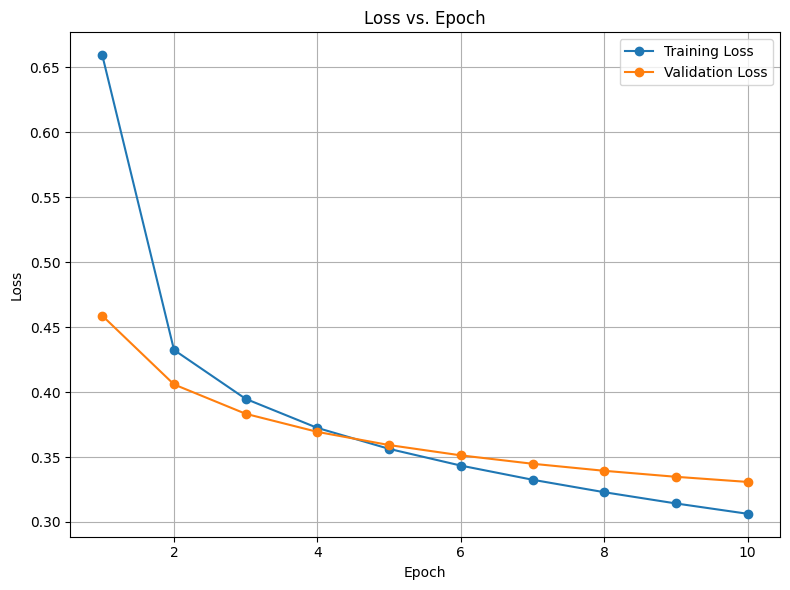

epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▄▅▅▆▇▇▇██
train_loss,█▄▃▂▂▂▂▁▁▁
val_acc,▁▄▅▆▆▇▇▇██
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
train_acc,0.89363
train_loss,0.30629
val_acc,0.88167
val_loss,0.33082


In [ ]:
def main():
    with wandb.init() as run:
        # Best hyperparameters
        epochs = 10
        num_hidden_layers = 5
        num_neurons = 128
        learning_rate = 1e-4
        act_fn = 'tanh'
        optimizer = 'adam'
        batch_size = 64
        weight_init = 'xavier'
        l2_reg = 0

        # Define input dimension and layer configuration
        input_dim = 28 * 28
        layer_sizes = [input_dim] + [num_neurons] * num_hidden_layers

        # Initialize the neural network with the best hyperparameters
        nn = NeuralNetwork(
            layer_sizes=layer_sizes,
            weight_init=weight_init,
            activation=act_fn,
            weight_decay=l2_reg
        )



        # Split data into train, validation, and test sets
        (X_train, Y_train_raw, Y_train_enc,
         X_val, Y_val_raw, Y_val_enc,
         X_test, Y_test_raw, Y_test_enc) = nn.split_data()

        # Train the model using the best hyperparameters
        final_params, tr_losses, val_losses = nn.train_model(
            x_train=X_train,
            y_train_raw=Y_train_raw,
            y_train_enc=Y_train_enc,
            x_val=X_val,
            y_val_raw=Y_val_raw,
            y_val_enc=Y_val_enc,
            num_hidden_layers=num_hidden_layers,
            num_neurons=num_neurons,
            optimizer_type=optimizer,
            learning_rate=learning_rate,
            num_epochs=epochs,
            batch_size=batch_size,
            weight_decay=l2_reg
        )

        #  predictions on the test set by forward pass
        y_hat, _, _ = nn.forward_propagation(X_test, None, num_hidden_layers, num_neurons)
        predicted_labels = np.argmax(y_hat, axis=1)
        true_labels = Y_test_raw

        # class names for the confusion matrix
        class_names = [
            'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
            'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
        ]


        wandb.log({
            "confusion_matrix": wandb.plot.confusion_matrix(
                preds=predicted_labels,
                y_true=true_labels,
                class_names=class_names
            )
        })

# Launch the confusion matrix
wandb.agent(sweep_id, function=main, count=1)
wandb.finish()
